In [28]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
from sklearn import linear_model

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

Using TensorFlow backend.


## LSTM REGRESSOR
### Predicts next week´s change in cases by county given various mobility and socio-economic data points

### Read the NYT Data for Infections

In [3]:
df_nyt = pd.read_csv('mortality_data/us-counties.csv')

#### process the data for analysis

In [4]:
weeks = np.array([27, 29, 34, 26, 31, 33, 23, 25, 32, 30, 24, 28, 35, 36, 37, 38])

In [30]:
df_nyt.loc[:,'fips'] = df_nyt.fips.apply(lambda x: str(x)[:-2].zfill(5))

df_nyt.loc[:,'state'] = df_nyt.fips.apply(lambda x: str(x)[:2])
df_nyt.loc[:,'county'] = df_nyt.fips.apply(lambda x: str(x)[2:5])

df_nyt.loc[:,'date'] = pd.to_datetime(df_nyt.date)
df_nyt.loc[:,'week'] =df_nyt.date.apply(lambda x: x.isocalendar()[1])

df_nyt.loc[:,'valid_week'] = df_nyt.week.apply(lambda x: x in weeks)
df_nyt = df_nyt.loc[df_nyt.valid_week]

#### group by counties and take the sum of cases

In [6]:
labels = df_nyt[['week','state','county','cases']]
labels = labels.groupby(['week','state','county'])['cases'].mean().reset_index()


#### shift each week by 1 period to get the new cases in a given week, and shift again to find the change in new cases

In [7]:
labels.state.unique()

array(['00', '01', '02', '04', '05', '06', '08', '09', '10', '11', '12',
       '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47',
       '48', '49', '50', '51', '53', '54', '55', '56', '72', '78', '69'],
      dtype=object)

In [8]:
collection = []

for state in labels.state.unique():
    print(state)
    sub1 = labels.loc[labels.state==state]
    for county in sub1.county.unique():
        sub2 = sub1.loc[sub1.county==county]

        sub2 = sub2[['week','cases']]
        sub2 = sub2.set_index('week')

        
        shifted = (sub2.cases-sub2.cases.shift(1)).dropna()
        #shifted = (shifted-shifted.shift(1)).dropna()
        shifted =shifted.reset_index()
        
      
        shifted['county'] = [str(county) for i in range(len(shifted))]
        shifted['state'] = [str(state) for i in range(len(shifted))]
        

        shifted=shifted.reset_index()[['week','state','county','cases']]
        
        
        collection.append(pd.DataFrame(shifted))

        
labels = pd.concat(collection).reset_index()

00
01
02
04
05
06
08
09
10
11
12
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
44
45
46
47
48
49
50
51
53
54
55
56
72
78
69


### Read the Processed Mobility Data

In [9]:
df_mobility = pd.read_csv('social_mobility_Data/combined/features.csv')

#### process data for analysis

In [10]:
df_mobility.loc[:,'date'] = pd.to_datetime(df_mobility.date)
df_mobility.loc[:,'week'] =df_mobility.date.apply(lambda x: x.isocalendar()[1])

df_mobility.loc[:,'state'] = df_mobility.state.apply(lambda x: str(x).zfill(2))
df_mobility.loc[:,'county'] = df_mobility.county.apply(lambda x: str(x).zfill(3))



In [11]:
mobility = df_mobility.groupby(['week','state','county']).mean().reset_index()[['week', 'state', 'county', 'median_home_dwell_time',
       'median_percentage_time_home', 'median_non_home_dwell_time',
       'mean_home_dwell_time', 'mean_non_home_dwell_time',
       'completely_home_device_count', 'part_time_work_behavior_devices',
       'full_time_work_behavior_devices', 'delivery_behavior_devices']]

In [12]:
mobility.head()

,week,state,county,median_home_dwell_time,median_percentage_time_home,median_non_home_dwell_time,mean_home_dwell_time,mean_non_home_dwell_time,completely_home_device_count,part_time_work_behavior_devices,full_time_work_behavior_devices,delivery_behavior_devices
0,23,01,015,696.200368,74.552058,165.942800,674.568985,323.131466,0.226135,0.089999,0.039909,0.043576
1,23,01,033,683.236348,73.088161,192.713054,661.334168,339.279151,0.203815,0.093365,0.036476,0.054458
2,23,01,037,611.920985,70.949040,190.211995,627.462955,334.731263,0.194054,0.097009,0.036080,0.041373
3,23,01,087,606.422368,79.060921,111.440877,631.176031,285.876579,0.283094,0.069815,0.037740,0.053090
4,23,01,103,689.038542,75.305507,167.521292,670.122255,321.033063,0.222106,0.092757,0.040817,0.045789


### Read the census data

In [13]:
def get_data(path,column):
    low = pd.read_csv(path,index_col=0)

    low.loc[:,'census_block_group'] = low.census_block_group.apply(lambda x: str(x).zfill(12))
    low.loc[:,'state'] = low.census_block_group.apply(lambda x: str(x)[:2])
    low.loc[:,'county'] = low.census_block_group.apply(lambda x: str(x)[2:5])


    low = low[['state','county',column]]
    low = low.groupby(['state','county'])[column].mean().reset_index()
    return low
    
def get_data2(path,column):
    low = pd.read_csv(path,index_col=0)

    low.loc[:,'census_block_group'] = low.census_block_group.apply(lambda x: str(x).zfill(12))
    low.loc[:,'state'] = low.census_block_group.apply(lambda x: str(x)[:2])
    low.loc[:,'county'] = low.census_block_group.apply(lambda x: str(x)[2:5])


    low = low[['state','county',column]]
    low = low.groupby(['state','county'])[column].sum().reset_index()
    return low

def merger(data1,data2):
    return pd.merge(data1,data2,how='left',on=['state','county'])

#### merge with the mobility data

In [14]:
df1 = merger(mobility,get_data('census_data/low_inc.csv','low_inc'))
df2 = merger(df1,get_data('census_data/white.csv','white'))
df3 = merger(df2,get_data('census_data/pop_density.csv','pop_density'))
df4 = merger(df3,get_data2('census_data/pop.csv','pop'))

#### merge with the NYT data

In [15]:
df4.head()

,week,state,county,median_home_dwell_time,median_percentage_time_home,median_non_home_dwell_time,mean_home_dwell_time,mean_non_home_dwell_time,completely_home_device_count,part_time_work_behavior_devices,full_time_work_behavior_devices,delivery_behavior_devices,low_inc,white,pop_density,pop
0,23,01,015,696.200368,74.552058,165.942800,674.568985,323.131466,0.226135,0.089999,0.039909,0.043576,0.437855,0.739534,0.000285,115883
1,23,01,033,683.236348,73.088161,192.713054,661.334168,339.279151,0.203815,0.093365,0.036476,0.054458,0.432565,0.779200,0.000378,54377
2,23,01,037,611.920985,70.949040,190.211995,627.462955,334.731263,0.194054,0.097009,0.036080,0.041373,0.540780,0.661191,0.000015,10864
3,23,01,087,606.422368,79.060921,111.440877,631.176031,285.876579,0.283094,0.069815,0.037740,0.053090,0.522533,0.152767,0.000129,19684
4,23,01,103,689.038542,75.305507,167.521292,670.122255,321.033063,0.222106,0.092757,0.040817,0.045789,0.414455,0.791967,0.000518,119555


In [16]:
labels = labels[['week','state','county','cases']]
labels.loc[:,'state'] = labels.state.apply(lambda x: str(x).zfill(2))
labels.loc[:,'county'] = labels.county.apply(lambda x: str(x).zfill(3))

In [17]:
labels.head()

,week,state,county,cases
0,24,00,00n,-320.679572
1,25,00,00n,39.436599
2,26,00,00n,-129.101845
3,27,00,00n,241.510761
4,28,00,00n,123.478906


In [39]:
matrix = pd.merge(df4,labels,how='left',on=['week','state','county'])
matrix.cases.fillna(0,inplace=True)

In [40]:
matrix.head()

,week,state,county,median_home_dwell_time,median_percentage_time_home,median_non_home_dwell_time,mean_home_dwell_time,mean_non_home_dwell_time,completely_home_device_count,part_time_work_behavior_devices,full_time_work_behavior_devices,delivery_behavior_devices,low_inc,white,pop_density,pop,cases
0,23,01,015,696.200368,74.552058,165.942800,674.568985,323.131466,0.226135,0.089999,0.039909,0.043576,0.437855,0.739534,0.000285,115883,0.0
1,23,01,033,683.236348,73.088161,192.713054,661.334168,339.279151,0.203815,0.093365,0.036476,0.054458,0.432565,0.779200,0.000378,54377,0.0
2,23,01,037,611.920985,70.949040,190.211995,627.462955,334.731263,0.194054,0.097009,0.036080,0.041373,0.540780,0.661191,0.000015,10864,0.0
3,23,01,087,606.422368,79.060921,111.440877,631.176031,285.876579,0.283094,0.069815,0.037740,0.053090,0.522533,0.152767,0.000129,19684,0.0
4,23,01,103,689.038542,75.305507,167.521292,670.122255,321.033063,0.222106,0.092757,0.040817,0.045789,0.414455,0.791967,0.000518,119555,0.0


#### shitft the cases by one time step back so we can predict next weeks

In [20]:
#scale by the population
#matrix.cases = matrix.cases / matrix['pop']

In [21]:
collection = []
for state in matrix.state.unique():
    sub1 = matrix.loc[matrix.state == state]
    for county in sub1.county.unique():
        sub2 = sub1.loc[sub1.county==county]
        sub2['shifted'] = sub2.cases.shift(periods=-1)
        collection.append(sub2)


In [22]:
matrix = pd.concat(collection)

In [23]:
matrix.head()

,week,state,county,median_home_dwell_time,median_percentage_time_home,median_non_home_dwell_time,mean_home_dwell_time,mean_non_home_dwell_time,completely_home_device_count,part_time_work_behavior_devices,full_time_work_behavior_devices,delivery_behavior_devices,low_inc,white,pop_density,pop,cases,shifted
0,23,01,015,696.200368,74.552058,165.942800,674.568985,323.131466,0.226135,0.089999,0.039909,0.043576,0.437855,0.739534,0.000285,115883,0.000000,0.000144
324,24,01,015,692.449821,74.869153,167.732934,673.959665,314.478093,0.233734,0.093172,0.042873,0.045135,0.437855,0.739534,0.000285,115883,0.000144,0.000134
648,25,01,015,715.306842,75.963155,186.968884,687.154278,327.722535,0.234762,0.099637,0.046523,0.049140,0.437855,0.739534,0.000285,115883,0.000134,0.000182
972,26,01,015,729.716672,76.098765,182.090292,699.797506,326.955218,0.235278,0.098060,0.048702,0.047329,0.437855,0.739534,0.000285,115883,0.000182,0.000657
1296,27,01,015,705.665130,76.616434,174.289989,683.902553,332.021528,0.243765,0.096922,0.044363,0.054539,0.437855,0.739534,0.000285,115883,0.000657,0.001212


### LSTM

In [24]:
matrix.dropna(inplace=True)

In [25]:
features = ['median_home_dwell_time',
       'median_percentage_time_home', 'median_non_home_dwell_time',
       'mean_home_dwell_time', 'mean_non_home_dwell_time',
       'completely_home_device_count', 'part_time_work_behavior_devices',
       'full_time_work_behavior_devices', 'delivery_behavior_devices', 'low_inc',
       'white', 'pop_density','pop','cases']
value = ['shifted']

In [26]:
x_train,y_train = matrix[features].iloc[:len(matrix)-2,:].values,matrix[value].iloc[:len(matrix)-2,:].values
x_test,y_test = matrix[features].iloc[len(matrix)-2:,:].values,matrix[value].iloc[len(matrix)-2:,:].values

x_train_ = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test_ = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [35]:

def lstm():

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(100, input_shape=(x_train_.shape[1], x_train_.shape[2])))
    #model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

def evaluate_model(state,county):
    
    matrix_sub = matrix.loc[(matrix.state==state)&(matrix.county==county)]

    scalar = MinMaxScaler()
    scalar.fit(matrix_sub[features][features])
    matrix_sub[features] = scalar.transform(matrix_sub[features][features])

    x_train,y_train = matrix_sub[features].iloc[:len(matrix_sub)-2,:].values,matrix_sub[value].iloc[:len(matrix_sub)-2,:].values
    x_test,y_test = matrix_sub[features].iloc[len(matrix_sub)-2:,:].values,matrix_sub[value].iloc[len(matrix_sub)-2:,:].values

    x_train_ = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test_ = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    estimator = KerasRegressor(build_fn=lstm, epochs=50,batch_size=1, verbose=0)

    history = estimator.fit(x_train_, y_train)

    y_pred = estimator.predict(x_test_).reshape(2)
    y_test.reshape(2)

    plt.plot(np.arange(2),y_pred,label='prediction')
    plt.plot(np.arange(2),y_test,label='actual')
    plt.legend()
    plt.xlabel('Test Weeks, August 17-31, 2020')
    plt.xticks(np.arange(0, 2, step=1))
    plt.ylabel('Change in Infected Population Ratio')
    plt.title('Predicted vs True Infection Ratio for County {}, State {}'.format(county,state))
    plt.show()
    
    
    return

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


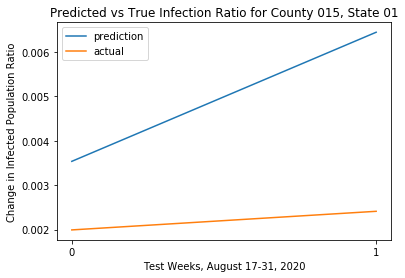

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


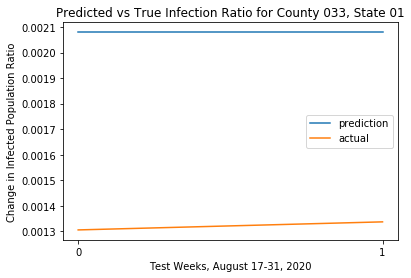

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


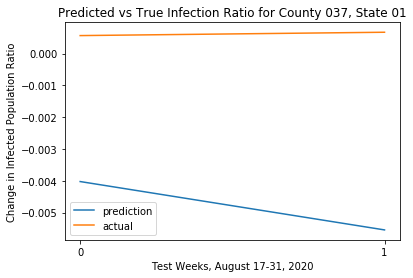

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


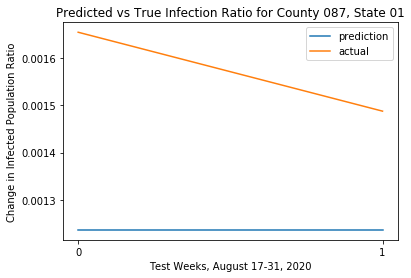

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


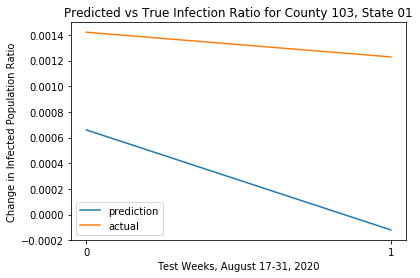

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


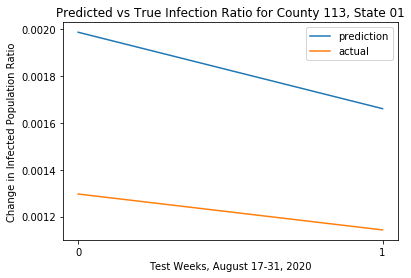

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


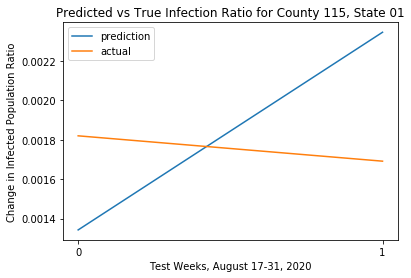

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


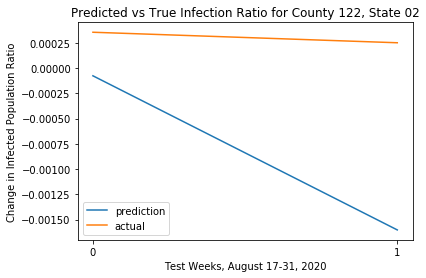

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


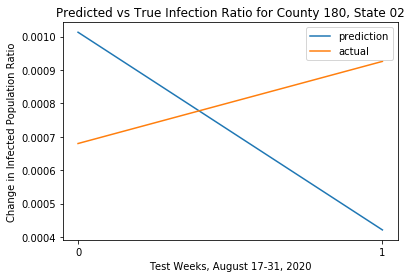

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


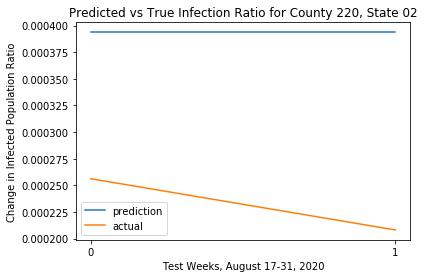

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


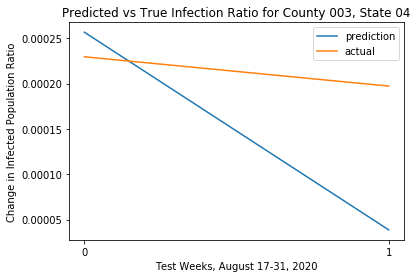

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


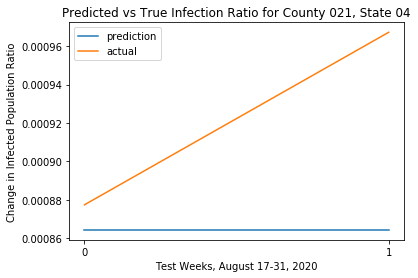

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


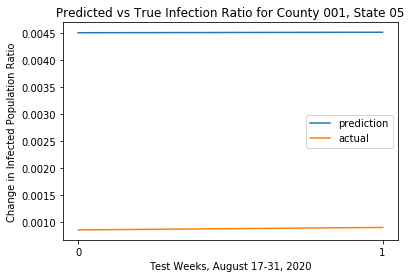

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


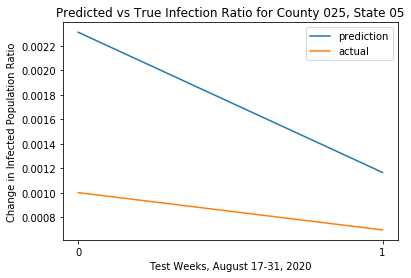

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


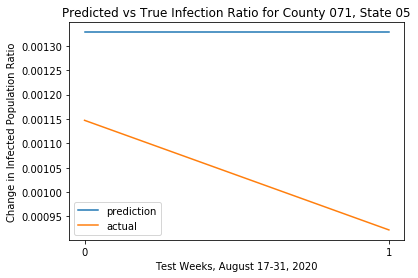

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


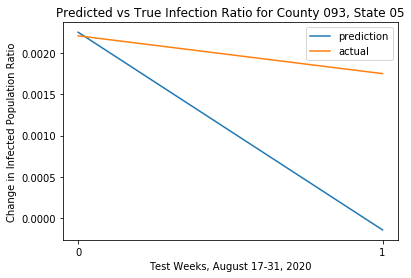

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


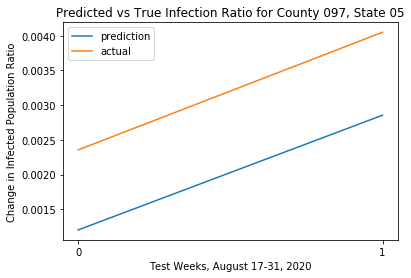

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


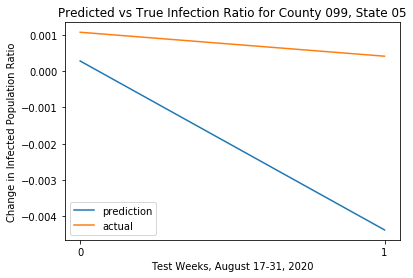

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


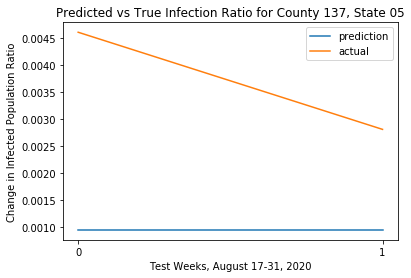

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


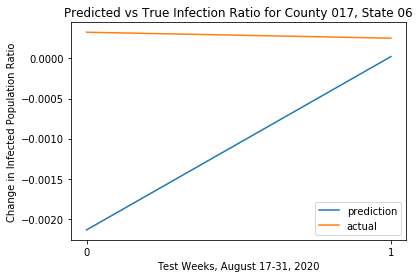

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


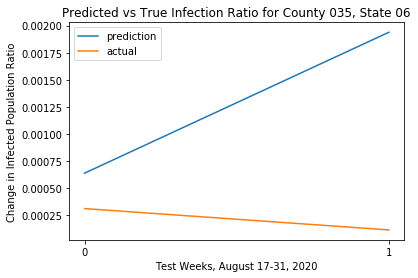

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


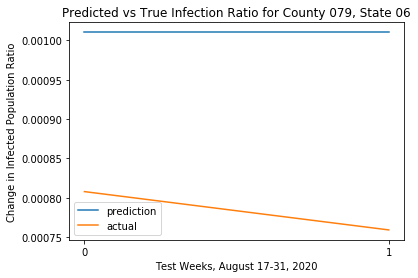

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


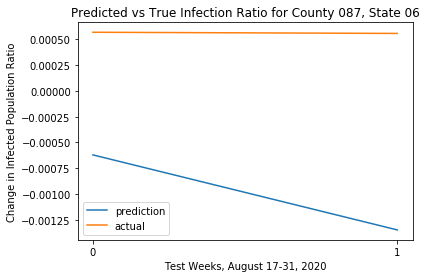

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


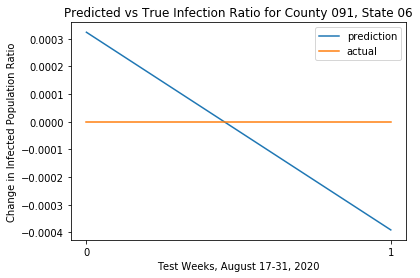

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


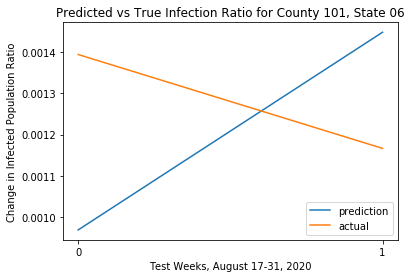

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


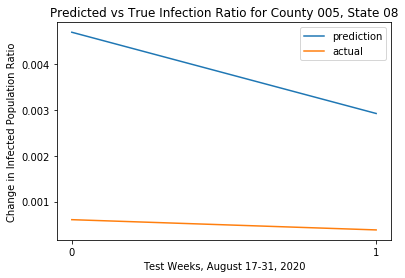

/Users/Daues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
Exception ignored in: <function BaseSession._Callable.__del__ at 0x7fdf474b51e0>
Traceback (most recent call last):
  File "/Users/Daues/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1448, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

In [36]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

results = {}
for state in matrix.state.unique():
    sub = matrix.loc[matrix.state == state]
    for county in sub.county.unique():
        evaluate_model(state,county)
        
        